In [1]:
from sklearn.feature_extraction.text import TfidfTransformer  # TF-IDF向量转换类
from sklearn.feature_extraction.text import CountVectorizer  # 词频矩阵
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier  # 结合SVM的多分类组合辅助器
import sklearn.svm as svm  # SVM辅助器
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate

from os import listdir
import os
import jieba

from time import time
import datetime

In [2]:
def getStopWord(inputPath):
    with open(inputPath, "r", encoding='utf-8') as file:
        content = file.read()
        file.close()
    stopWordList = content.splitlines()
    return stopWordList

stopwords_filePath = "B:\\code_master\\code\\03DataSet\\停用词01.txt"
stopWordList = getStopWord(stopwords_filePath)

In [3]:
# getDataLabelList() : 取数据、标签列表
def getDataLabelList(inputPath):
    dataList = []
    labelList = []
    fatherLists = listdir(inputPath) # 目录 ['xx罪.txt','xx罪.txt',...]
    for eachDir in fatherLists:  # 遍历目录中各个文件
        eachPath = inputPath +"\\"+ eachDir  # 保存目录中每个文件路径，便于遍历二级文件  G:\\dataSetTest\\xx罪.txt
        with open(eachPath, 'r', encoding="utf-8") as f:
            content = f.readlines()
            for i in range(len(content)):
                labelList.append(eachDir.replace('.txt',''))
                dataList.append(" ".join(jieba.cut(content[i].strip())))
            f.close()
    return dataList, labelList



# 训练集的特征、标签列表
fileTrainPath = "B:\\code_master\\code\\03DataSet\\dataTrainSet_50To200"
dataTrain_list, labelTrain_list = getDataLabelList(fileTrainPath)
# 测试集的特征、标签列表
fileTestPath = "B:\\code_master\\code\\03DataSet\\dataTestSet_50To200"
dataTest_list, labelTest_list = getDataLabelList(fileTestPath)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\bigdata\AppData\Local\Temp\jieba.cache
Loading model cost 0.727 seconds.
Prefix dict has been built successfully.


In [5]:
# getPreResult() : 输入案例并返回预测结果
vectorizer = CountVectorizer(stop_words=stopWordList
                             # , min_df=0.02
                             # , max_df=0.5
                             , max_features= 5000
                             )  # 完善min_df的取值 ，学习曲线？？？
# 其他类别专用分类，该类会将文本中的词语转换为词频矩阵，矩阵元素a[i][j] 表示j词在i类文本下的词频
transformer = TfidfTransformer()  # 该类会统计每个词语的tf-idf权值
#对训练集向量化
cipinTrain = vectorizer.fit_transform(dataTrain_list)
tfidfTrain = transformer.fit_transform(cipinTrain)  # if-idf中的输入为已经处理过的词频矩阵
print("(tfidfTrain.toarray()).shape : ")
print((tfidfTrain.toarray()).shape)
#对测试集向量化
cipinTest = vectorizer.transform(dataTest_list)
tfidfTest = transformer.transform(cipinTest)
print("(tfidfTest.toarray()).shape : ")
print((tfidfTest.toarray()).shape)

# solver_list = ['newton-cg','lbfgs','sag','saga']
# for i in range(len(solver_list)):
for multi_class in ('multinomial','ovr'):
    # print("调参solver: ",solver_list[i])
    print("multi_class:",multi_class)
    #用训练集训练模型
    # model = OneVsRestClassifier(svm.SVC(kernel='linear')) #实例化模型
    LR_model = LogisticRegression(
                                   # multi_class="multinomial"
                                  multi_class=multi_class
                                  # , solver=solver_list[i]
                                  # , random_state=2
                                  )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

    ytrain_pred = LR_model.predict(tfidfTrain)
    print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
    print("")


    ytest_pred = LR_model.predict(tfidfTest)
    print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
    print("")

(tfidfTrain.toarray()).shape : 
(16556, 5000)
(tfidfTest.toarray()).shape : 
(6927, 5000)
multi_class: multinomial
对训练集进行模型评估, Start running time: 2022-04-18 22:10:37.794833
accuracy_score : 0.9313843923653057

对测试集集进行模型评估, Start running time: 2022-04-18 22:10:37.846692
accuracy_score : 0.8084307781146239

multi_class: ovr
对训练集进行模型评估, Start running time: 2022-04-18 22:11:00.377624
accuracy_score : 0.9238946605460256

对测试集集进行模型评估, Start running time: 2022-04-18 22:11:00.442450
accuracy_score : 0.8074202396419806



In [14]:
import numpy as np
import matplotlib.pyplot as plt

lr = []
lrtest = []

for i in np.arange(1,201,10):
    LR_model = LogisticRegression(
        multi_class="multinomial"
        , solver = 'saga'
        , max_iter=i 
    )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)
    ytrain_pred = LR_model.predict(tfidfTrain)
    ytest_pred = LR_model.predict(tfidfTest)
    
    lr.append(metrics.accuracy_score(labelTrain_list, ytrain_pred))
    lrtest.append(metrics.accuracy_score(labelTest_list, ytest_pred))
print(lr)
print(lrtest)
    
#     graph = [lr,lrtest]
#     color = ["black","gray"]
#     label = ["Lr","Lrtest"]
#     plt.figure(figsize=(20,5))
#     for i in range(len(graph)):
# #         plt.plot(np.arange(1,201,10),lr,'black',label='lr')
#         plt.plot(np.arange(1,201,10),graph[i],color[i],label=label[i])
#     plt.legend(loc=4)
#     plt.xticks(np.arange(1,201,10))
#     plt.show()

C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[0.8846339695578642, 0.931505194491423, 0.9315655955544817, 0.9315655955544817, 0.9315655955544817, 0.9315655955544817, 0.9315655955544817, 0.931505194491423, 0.931505194491423, 0.9314447934283644, 0.9315655955544817, 0.9315655955544817, 0.9315655955544817, 0.931505194491423, 0.931505194491423, 0.931505194491423, 0.931505194491423, 0.9315655955544817, 0.9314447934283644, 0.9315655955544817]
[0.7672874260141476, 0.808575140753573, 0.808575140753573, 0.8084307781146239, 0.808575140753573, 0.808575140753573, 0.808575140753573, 0.808719503392522, 0.8084307781146239, 0.808575140753573, 0.808575140753573, 0.808575140753573, 0.8082864154756749, 0.808719503392522, 0.808575140753573, 0.8084307781146239, 0.808719503392522, 0.808575140753573, 0.808719503392522, 0.808719503392522]


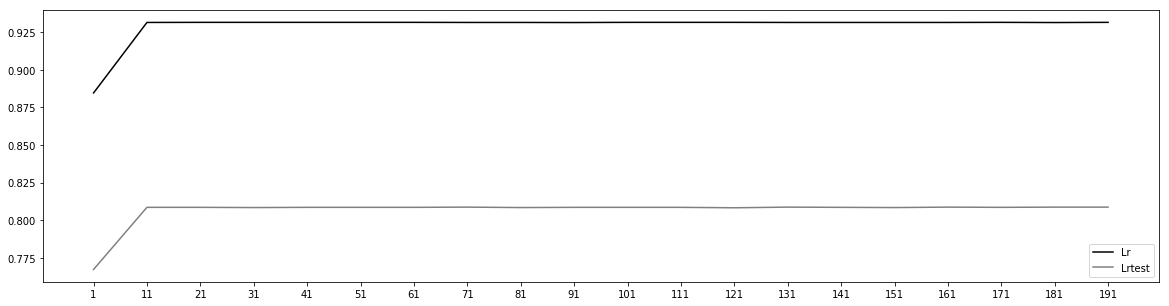

In [15]:
graph = [lr,lrtest]
color = ["black","gray"]
label = ["Lr","Lrtest"]
plt.figure(figsize=(20,5))
for i in range(len(graph)):
#         plt.plot(np.arange(1,201,10),lr,'black',label='lr')
    plt.plot(np.arange(1,201,10),graph[i],color[i],label=label[i])
plt.legend(loc=4)
plt.xticks(np.arange(1,201,10))
plt.show()

In [18]:
solver_list = ['newton-cg', 'lbfgs', 'sag', 'saga']
for i in range(len(solver_list)):
    print("调参solver: ", solver_list[i])
    #用训练集训练模型
    # model = OneVsRestClassifier(svm.SVC(kernel='linear')) #实例化模型
    LR_model = LogisticRegression(
        multi_class="multinomial"
        # multi_class=multi_class
        , solver= solver_list[i]
        , max_iter=11
        # , random_state=2

                                  )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

    ytrain_pred = LR_model.predict(tfidfTrain)
    print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
    print("")


    ytest_pred = LR_model.predict(tfidfTest)
    print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
    print("")


调参solver:  newton-cg


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


对训练集进行模型评估, Start running time: 2022-04-18 23:14:10.225704
accuracy_score : 0.9313843923653057

对测试集集进行模型评估, Start running time: 2022-04-18 23:14:10.300504
accuracy_score : 0.8082864154756749

调参solver:  lbfgs


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


对训练集进行模型评估, Start running time: 2022-04-18 23:14:17.042528
accuracy_score : 0.8811911089635177

对测试集集进行模型评估, Start running time: 2022-04-18 23:14:17.100374
accuracy_score : 0.7763822722679371

调参solver:  sag


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


对训练集进行模型评估, Start running time: 2022-04-18 23:14:23.336749
accuracy_score : 0.931505194491423

对测试集集进行模型评估, Start running time: 2022-04-18 23:14:23.381627
accuracy_score : 0.8077089649198788

调参solver:  saga
对训练集进行模型评估, Start running time: 2022-04-18 23:14:32.288880
accuracy_score : 0.9313843923653057

对测试集集进行模型评估, Start running time: 2022-04-18 23:14:32.334757
accuracy_score : 0.808575140753573



C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [19]:
solver_list = ['newton-cg', 'lbfgs', 'sag', 'saga']
for i in range(len(solver_list)):
    print("调参solver: ", solver_list[i])
    #用训练集训练模型
    # model = OneVsRestClassifier(svm.SVC(kernel='linear')) #实例化模型
    LR_model = LogisticRegression(
        multi_class="multinomial"
        # multi_class=multi_class
        , solver= solver_list[i]
        , max_iter=20
        # , random_state=2

                                  )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

    ytrain_pred = LR_model.predict(tfidfTrain)
    print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
    print("")


    ytest_pred = LR_model.predict(tfidfTest)
    print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
    print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
    print("")

调参solver:  newton-cg
对训练集进行模型评估, Start running time: 2022-04-18 23:18:06.832840
accuracy_score : 0.9313843923653057

对测试集集进行模型评估, Start running time: 2022-04-18 23:18:06.908637
accuracy_score : 0.8084307781146239

调参solver:  lbfgs


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


对训练集进行模型评估, Start running time: 2022-04-18 23:18:18.125730
accuracy_score : 0.9208746073930901

对测试集集进行模型评估, Start running time: 2022-04-18 23:18:18.183577
accuracy_score : 0.8038111736682546

调参solver:  sag


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


对训练集进行模型评估, Start running time: 2022-04-18 23:18:29.585179
accuracy_score : 0.9313843923653057

对测试集集进行模型评估, Start running time: 2022-04-18 23:18:29.630104
accuracy_score : 0.8084307781146239

调参solver:  saga
对训练集进行模型评估, Start running time: 2022-04-18 23:18:45.083859
accuracy_score : 0.931505194491423

对测试集集进行模型评估, Start running time: 2022-04-18 23:18:45.133725
accuracy_score : 0.808575140753573



In [20]:
LR_model = LogisticRegression(
    penalty="l1"
#     , C = 0.5
    ,multi_class="multinomial"
    # multi_class=multi_class
    , solver= 'saga'
    , max_iter=20
    # , random_state=2

                              )
LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

ytrain_pred = LR_model.predict(tfidfTrain)
print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
print("")


ytest_pred = LR_model.predict(tfidfTest)
print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
print("")

对训练集进行模型评估, Start running time: 2022-04-18 23:21:18.937058
accuracy_score : 0.8765402271079971

对测试集集进行模型评估, Start running time: 2022-04-18 23:21:18.986924
accuracy_score : 0.8088638660314711



C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [23]:
LR_model = LogisticRegression(
#     penalty="l1"
#     , C = 0.5
    multi_class="multinomial"
    # multi_class=multi_class
    , solver= 'saga'
    , max_iter=20
    , random_state=2
     )
LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

ytrain_pred = LR_model.predict(tfidfTrain)
print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
print("")


ytest_pred = LR_model.predict(tfidfTest)
print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
print("")

对训练集进行模型评估, Start running time: 2022-04-18 23:22:47.341134
accuracy_score : 0.9314447934283644

对测试集集进行模型评估, Start running time: 2022-04-18 23:22:47.386013
accuracy_score : 0.808575140753573



C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


In [24]:
LR_model = LogisticRegression(
#     penalty="l1"
#     , C = 0.5
    multi_class="multinomial"
    # multi_class=multi_class
    , solver= 'saga'
    , max_iter=20
    , random_state=10
     )
LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

ytrain_pred = LR_model.predict(tfidfTrain)
print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
print("")


ytest_pred = LR_model.predict(tfidfTest)
print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
print("")

对训练集进行模型评估, Start running time: 2022-04-18 23:24:01.553425
accuracy_score : 0.9314447934283644

对测试集集进行模型评估, Start running time: 2022-04-18 23:24:01.598306
accuracy_score : 0.808575140753573



C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

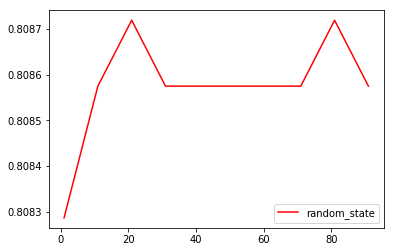

In [25]:
import matplotlib.pyplot as plt
test = []
for i in np.arange(1,101,10):
    
    LR_model = LogisticRegression(
    #     penalty="l1"
    #     , C = 0.5
        multi_class="multinomial"
        # multi_class=multi_class
        , solver= 'saga'
        , max_iter=20
        , random_state=i
     )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)
    score = LR_model.score(tfidfTest, labelTest_list)
    test.append(score)
plt.plot(np.arange(1,101,10),test,color="red",label="random_state")
plt.legend()
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt

LRTrain = []
LRTest = []

for i in np.arange(1,101,10):
    LR_model = LogisticRegression(
        multi_class="multinomial"
        , solver = 'saga'
        , max_iter=20 
        , random_state=i
    )
    LR_model = LR_model.fit(tfidfTrain, labelTrain_list)
    ytrain_pred = LR_model.predict(tfidfTrain)
    ytest_pred = LR_model.predict(tfidfTest)
    
    LRTrain.append(metrics.accuracy_score(labelTrain_list, ytrain_pred))
    LRTest.append(metrics.accuracy_score(labelTest_list, ytest_pred))
print(LRTrain)
print(LRTest)

C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  Conve

[0.931505194491423, 0.931505194491423, 0.931505194491423, 0.9313843923653057, 0.931505194491423, 0.9315655955544817, 0.931505194491423, 0.931505194491423, 0.931505194491423, 0.931505194491423]
[0.8082864154756749, 0.808575140753573, 0.808719503392522, 0.808575140753573, 0.808575140753573, 0.808575140753573, 0.808575140753573, 0.808575140753573, 0.808719503392522, 0.808575140753573]


C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


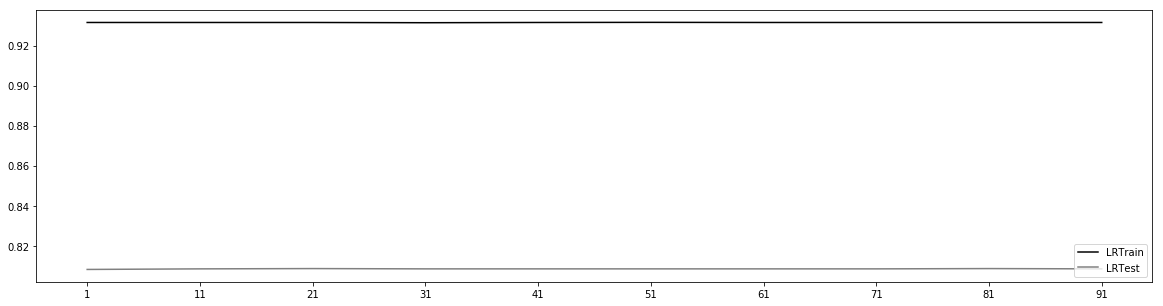

In [28]:
graph = [LRTrain,LRTest]
color = ["black","gray"]
label = ["LRTrain","LRTest"]
plt.figure(figsize=(20,5))
for i in range(len(graph)):
#         plt.plot(np.arange(1,201,10),lr,'black',label='lr')
    plt.plot(np.arange(1,101,10),graph[i],color[i],label=label[i])
plt.legend(loc=4)
plt.xticks(np.arange(1,101,10))
plt.show()

In [29]:
LR_model = LogisticRegression(
#     penalty="l1"
#     , C = 0.5
    multi_class="multinomial"
    # multi_class=multi_class
    , solver= 'saga'
    , max_iter=20
    , random_state=20
     )
LR_model = LR_model.fit(tfidfTrain, labelTrain_list)

ytrain_pred = LR_model.predict(tfidfTrain)
print("对训练集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("classification_report: ")
print(classification_report(labelTrain_list, ytrain_pred))
# print("accuracy_score :", metrics.accuracy_score(labelTrain_list, ytrain_pred))
print("")


ytest_pred = LR_model.predict(tfidfTest)
print("对测试集集进行模型评估, Start running time: %s" % datetime.datetime.now())
print("classification_report: ")
print(classification_report(labelTest_list, ytest_pred))
# print("accuracy_score :" , metrics.accuracy_score(labelTest_list, ytest_pred))
print("")

C:\Users\bigdata\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


对训练集进行模型评估, Start running time: 2022-04-18 23:47:49.096883
classification_report: 
                precision    recall  f1-score   support

         串通投标罪       0.93      0.97      0.95       141
         交通肇事罪       0.96      0.97      0.96       141
         介绍贿赂罪       0.86      0.91      0.88       141
         代替考试罪       0.91      0.96      0.93        50
  以危险方法危害公共安全罪       0.86      0.85      0.86       141
       传授犯罪方法罪       1.00      0.68      0.81        38
         传播性病罪       0.98      0.94      0.96        50
       传播淫秽物品罪       0.98      0.99      0.98       141
           伪证罪       0.92      0.92      0.92       141
         伪造货币罪       1.00      0.96      0.98        52
           侮辱罪       1.00      0.90      0.95        63
           侵占罪       0.90      0.78      0.84       141
     侵犯公民个人信息罪       0.99      0.96      0.98       141
        侵犯著作权罪       0.99      0.99      0.99       141
         保险诈骗罪       0.96      0.99      0.97       141
        信用卡诈骗罪      